# EWMA and PEWMA examples

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tsanomaly as ad

In [2]:
df = pd.read_csv("./data/DailyDelhiClimateTrain.csv").set_index("date")
df.index = pd.to_datetime(df.index)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


## EWMA

The exponentially-weighted moving average $\mu_t$ at time $t$ is given by

$$ \mu_t = \alpha X_t + (1 - \alpha) \mu_{t-1} $$

where $\alpha \in [0, 1]$ is a weight applied to the current time series value $X_t$.

To identify anomalies, we estimate a moving standard deviation $\sigma_t$.

$$ \nu_t = \alpha X_t^2 + (1 - \alpha) \nu_{t-1} $$
$$ \sigma_t = \sqrt{\nu_t - \mu_t^2} $$

Then we define a band given by $\mu \pm m\sigma_t$. Anomalies are values that fall outside the band.

In [3]:
def plot_ewma(df, start, end):
    nseries = df.shape[1]
    fig, ax = plt.subplots(nrows=nseries, ncols=1, figsize=(12, 3*nseries), tight_layout=True)
    for i, colname in enumerate(df.columns):
        x = df.loc[start:end, colname]
        result = ad.ewma(x, 0.2, 3.0)
        ad.plot_anomalies(ax[i], result, colname)

In [4]:
#plot_ewma(df, "2013-01-01", "2013-06-30")

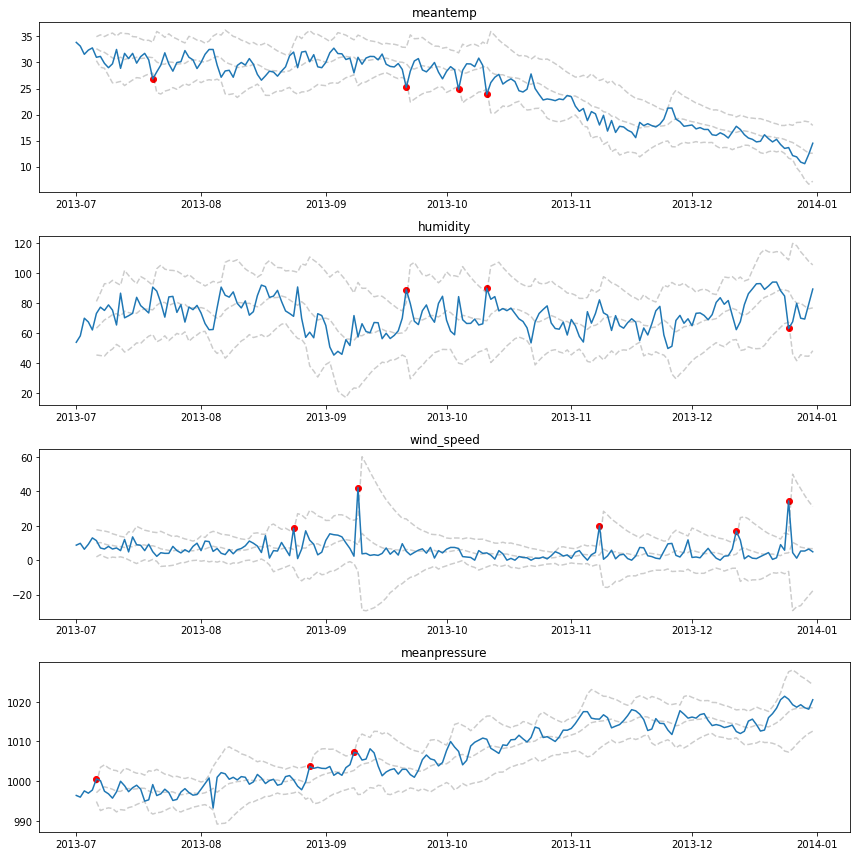

In [5]:
plot_ewma(df, "2013-07-01", "2013-12-31")

## PEWMA 

In [6]:
def plot_pewma(df, start, end):
    nseries = df.shape[1]
    fig, ax = plt.subplots(nrows=nseries, ncols=1, figsize=(12, 3*nseries), tight_layout=True)
    for i, colname in enumerate(df.columns):
        x = df.loc[start:end, colname]
        result = ad.pewma(x, 0.2, 0.8, 3.0, 10)
        ad.plot_anomalies(ax[i], result, colname)

In [7]:
#plot_pewma(df, "2013-01-01", "2013-06-30")

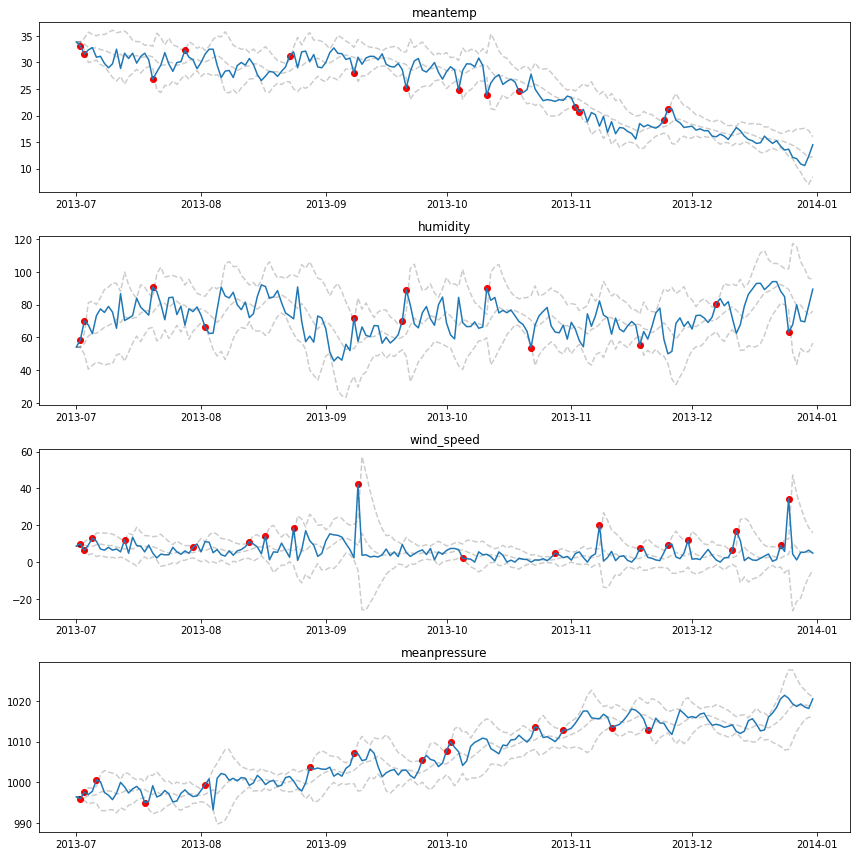

In [8]:
plot_pewma(df, "2013-07-01", "2013-12-31")

## PEWMA vs EWMA

In [9]:
def plot_one(ax, df, color):
    anom = df.loc[df["anomaly"], "x"]
    ax.plot(df["upper"], color=color, alpha=0.5, linestyle="--")
    ax.plot(df["lower"], color=color, alpha=0.5, linestyle="--")
    ax.plot(df["mean"], color=color, alpha=0.5, linestyle="--")
    ax.scatter(x=anom.index, y=anom.values, color="r")
    
def plot_pewma_vs_ewma(df, start, end):
    nseries = df.shape[1]
    fig, ax = plt.subplots(nrows=nseries, ncols=1, figsize=(12, 3*nseries), tight_layout=True)
    for i, colname in enumerate(df.columns):
        x = df.loc[start:end, colname]
        ewma_result = ad.ewma(x, 0.2, 3.0)
        pewma_result = ad.pewma(x, 0.2, 0.8, 3.0, 5)
        ax[i].set_title(colname)
        ax[i].plot(x, color="k", linestyle="-")
        plot_one(ax[i], ewma_result, color="blue")
        plot_one(ax[i], pewma_result, color="green")
        ax[i].legend(handles=[
            mpatches.Patch(color="k", label="Observed"),
            mpatches.Patch(color="blue", alpha=0.5, label="EWMA"),
            mpatches.Patch(color="green", alpha=0.5, label="PEWMA"),
            mpatches.Patch(color="r", label="Anomaly"),
        ])

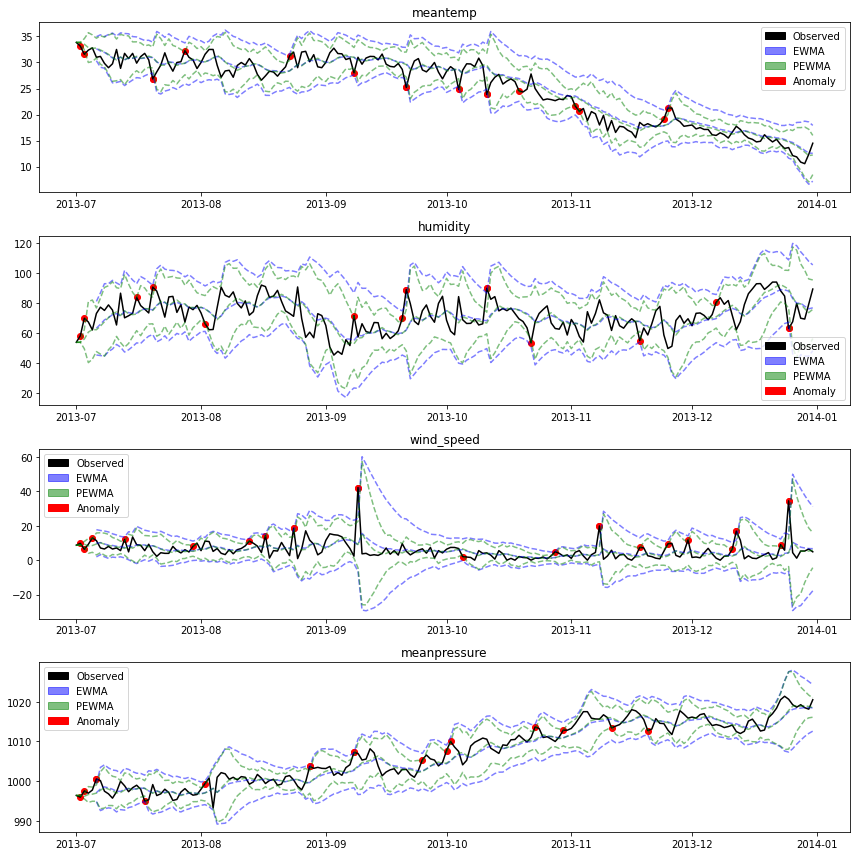

In [10]:
plot_pewma_vs_ewma(df, "2013-07-01", "2013-12-31")